In [1]:
#import os
# os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [1]:
import os
import argparse
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn import CrossEntropyLoss

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn import metrics

import warnings

warnings.filterwarnings('ignore')

import librosa
import glob
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
import random
from datasets import Dataset, Audio, Features, ClassLabel, Array2D
import datasets
from transformers import AutoFeatureExtractor
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer
from transformers import WhisperForAudioClassification, WhisperPreTrainedModel
from transformers.models.whisper.modeling_whisper import WhisperEncoder
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import math
from typing import Optional, Tuple, Union
from transformers.cache_utils import Cache, DynamicCache, EncoderDecoderCache, StaticCache
from transformers.modeling_outputs import Seq2SeqLMOutput
import torch
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch import nn
from transformers import set_seed
from torch.utils.data import DataLoader
from sklearn.metrics import log_loss, roc_auc_score

sns.set()

def seed_torch(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def one_hot_encode(labels, num_classes):
    # 初始化一个全零的数组
    one_hot = np.zeros((len(labels), num_classes))
    # 将对应的标签位置设置为1
    one_hot[np.arange(len(labels)), labels] = 1
    return one_hot


def softmax(x, axis=None):
    x_exp = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return x_exp / np.sum(x_exp, axis=axis, keepdims=True)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    logloss = log_loss(one_hot_encode(labels, 2), softmax(pred.predictions, axis=-1))

    return {"accuracy": acc, "f1": f1, 'logloss': logloss}


def load_to_dataset(audio_file_paths, tokens, decoder_mask, target):
    data = {'audio': audio_file_paths, 'decoder_input_ids': tokens,
            'decoder_attention_mask':decoder_mask, 'label': target}
    dataset = Dataset.from_dict(data)

    features = Features({
        'audio': Audio(sampling_rate=16000),
        'decoder_input_ids': datasets.Sequence(datasets.Value("int32")),  # ClassLabel(names=['control', 'mci', 'adrd'])
        'label': datasets.Sequence(datasets.Value("int32")),
        'decoder_attention_mask': datasets.Sequence(datasets.Value("int32")),
    })
    dataset = dataset.cast(features)

    return dataset


def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # there is no need for encoding label
    batch["label"] = batch["label"]
    return batch


def shift_tokens_right(input_ids: torch.Tensor, pad_token_id: int, decoder_start_token_id: int):
    """
    Shift input ids one token to the right.
    """
    shifted_input_ids = input_ids.new_zeros(input_ids.shape)
    shifted_input_ids[:, 1:] = input_ids[:, :-1].clone()
    shifted_input_ids[:, 0] = decoder_start_token_id

    if pad_token_id is None:
        raise ValueError("self.model.config.pad_token_id has to be defined.")
    # replace possible -100 values in labels by `pad_token_id`
    shifted_input_ids.masked_fill_(shifted_input_ids == -100, pad_token_id)

    return shifted_input_ids


class WhisperForConditionalGenerationMask(WhisperForConditionalGeneration):
    def forward(
        self,
        input_features: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.LongTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        past_key_values: Optional[Union[EncoderDecoderCache, Tuple[torch.FloatTensor]]] = None,
        decoder_inputs_embeds: Optional[Tuple[torch.FloatTensor]] = None,
        decoder_position_ids: Optional[Tuple[torch.LongTensor]] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        cache_position: Optional[torch.LongTensor] = None,
    ) -> Union[Tuple[torch.Tensor], Seq2SeqLMOutput]:

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if labels is not None:
            if labels.shape[1] > self.max_target_positions:
                raise ValueError(
                    f"Labels' sequence length {labels.shape[1]} cannot exceed the maximum allowed length of {self.max_target_positions} tokens."
                )
            if decoder_input_ids is None and decoder_inputs_embeds is None:
                decoder_input_ids = shift_tokens_right(
                    labels, self.config.pad_token_id, self.config.decoder_start_token_id
                )

        outputs = self.model(
            input_features,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            encoder_outputs=encoder_outputs,
            decoder_attention_mask=decoder_attention_mask,
            head_mask=head_mask,
            decoder_head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            decoder_inputs_embeds=decoder_inputs_embeds,
            decoder_position_ids=decoder_position_ids,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            cache_position=cache_position,
        )
        lm_logits = self.proj_out(outputs[0])

        loss = None
        if labels is not None:
            loss_fct = BCEWithLogitsLoss(reduction="none")
            # move labels to correct device to enable PP
            labels = labels.to(lm_logits.device)
            lm_logits = torch.gather(lm_logits, dim=2, index=decoder_input_ids.unsqueeze(-1)).squeeze(-1)[:, 4:]
            rpt = lm_logits.shape[1]
            labels = labels.repeat(1, rpt)
            mask = decoder_attention_mask[:, 4:]
            loss = loss_fct(lm_logits, labels.float())
            loss = loss.masked_fill(mask == 0, float('nan'))
            loss = torch.nanmean(loss, dim=1).mean()

            # loss = loss_fct(lm_logits.view(-1, self.config.vocab_size), labels.reshape(-1))
            # loss = loss_fct(lm_logits, labels.float())

        if not return_dict:
            output = (lm_logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return Seq2SeqLMOutput(
            loss=loss,
            logits=lm_logits,
            past_key_values=outputs.past_key_values,
            decoder_hidden_states=outputs.decoder_hidden_states,
            decoder_attentions=outputs.decoder_attentions,
            cross_attentions=outputs.cross_attentions,
            encoder_last_hidden_state=outputs.encoder_last_hidden_state,
            encoder_hidden_states=outputs.encoder_hidden_states,
            encoder_attentions=outputs.encoder_attentions,
        )

In [2]:
predicted, truths = [], []
oof_logits = []
for fold in range(5):
    label2id, id2label = dict(), dict()
    for i, label in enumerate(['wrong', 'correct']):
        label2id[label] = str(i)
        id2label[str(i)] = label
    global feature_extractor
    model_checkpoint = 'openai/whisper-small.en'
    feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
    df = pd.read_csv('fold.csv', index_col=0)
    trans = []
    for tsk, txt in zip(df.task.values, df.expected_text.values):
        if tsk == 'sentence_repetition':
            transcription = (
                "<|startoftranscript|>"
                "<|en|>"
                "<|transcribe|>"
                "<|notimestamps|>"
                f'{txt.capitalize()}'
            )

        else:
            transcription = (
                "<|startoftranscript|>"
                "<|en|>"
                "<|transcribe|>"
                "<|notimestamps|>"
                f' {txt}'
            )
        trans.append(transcription)
    processor = WhisperProcessor.from_pretrained(model_checkpoint)
    tok = processor.tokenizer(
        trans,
        return_tensors="pt",
        add_special_tokens=False,
        padding=True
    )  # Shape: [1, Sequence_Length]
    audio_file_paths = ['../inputs/train/' + x for x in df.filename]  # sorted(glob.glob('../inputs/train/*.wav'))
    # feats = torch.load('../notebooks/whisper_bert/roberta-large2.pth').float().numpy()[df.index.values]#[:2000]
    tokens = tok.input_ids
    masks = tok.attention_mask
    labels = np.array([[x] for x in df.score.values.astype(int).tolist()])
    fold_size = len(audio_file_paths) // 5 + 1
                               # )
    valid_ds = load_to_dataset(
        audio_file_paths=audio_file_paths[fold * fold_size:(fold + 1) * fold_size],
        tokens=tokens[fold * fold_size:(fold + 1) * fold_size],
        decoder_mask=masks[fold * fold_size:(fold + 1) * fold_size],
        target=labels[fold * fold_size:(fold + 1) * fold_size])
    # train_ds = train_ds.map(prepare_dataset, remove_columns="audio")
    valid_ds = valid_ds.map(prepare_dataset, remove_columns="audio")
    # print(len(train_ds), len(valid_ds))
    # train_ds = train_ds.with_format("np")
    valid_ds = valid_ds.with_format("np")
    
    model_checkpoint = f'./weights/oof-small.en/fold_{fold}/checkpoint-476'

    model = WhisperForConditionalGenerationMask.from_pretrained(model_checkpoint).cuda()
    # emb = nn.Linear(in_features=768, out_features=2, bias=True)
    # model.set_output_embeddings(emb)
    # model.config.vocab_size = 2
    num_labels = len(id2label)

    dl = DataLoader(valid_ds, num_workers=4, batch_size=16, shuffle=False)

    pred = []
    labels = []
    logits = []
    with torch.no_grad():
        for data in tqdm(dl):
            label = data['label']
            del data['label']
            data = {k: v.cuda() for k, v in data.items()}
            with torch.cuda.amp.autocast():
                r = model(**data)
            lm_logits = torch.gather(r['logits'], dim=2, index=data['decoder_input_ids'].unsqueeze(-1)).squeeze(-1)[:, 4:]
            rpt = lm_logits.shape[1]
            mask = data['decoder_attention_mask'][:, 4:]
            masked_logit = lm_logits.masked_fill(mask == 0, float('nan'))
            logits.append(masked_logit.cpu())
            agg_logit = torch.nanmean(masked_logit, dim=1)
            pred.append(torch.sigmoid(agg_logit).cpu().numpy())
            labels.append(label.cpu().reshape(-1))
            # break

    preds = np.concatenate(pred)
    labels = np.concatenate(labels)
    
    predicted.append(preds)
    truths.append(labels)
    oof_logits.append(torch.cat(logits))
    
    # break

100%|██████████| 476/476 [00:39<00:00, 11.98it/s]


In [3]:
prob = np.concatenate(predicted)
truth = np.concatenate(truths)
logit = torch.cat(oof_logits)

df['prob'] = prob

In [4]:
df[(df.task == 'sentence_repetition') & (df.score == 0)].sort_values('filename').head(20)

,filename,task,expected_text,grade,score,fold,prob
3487,jvmvgk.wav,sentence_repetition,instead of drinking his milk willie ate a gree...,KG,0.0,0,2.980232e-06
5000,jvnyso.wav,sentence_repetition,the children can play but they need to be quiet,2,0.0,0,7.426758e-01
10233,jvoirv.wav,sentence_repetition,the small truck was hit by the car that was go...,KG,0.0,1,8.166504e-02
17914,jvpdlj.wav,sentence_repetition,the children can play but they need to be quiet,KG,0.0,2,9.338379e-03
20127,jvpuql.wav,sentence_repetition,instead of drinking his milk willie ate a gree...,2,0.0,2,4.947186e-06
9394,jvqjyt.wav,sentence_repetition,instead of drinking his milk willie ate a gree...,KG,0.0,1,2.741814e-06
26827,jvquwn.wav,sentence_repetition,instead of drinking his milk willie ate a gree...,2,0.0,3,7.450581e-06
24205,jvrgdy.wav,sentence_repetition,was the boy with his friends during the movie,1,0.0,3,8.168221e-04
5984,jvrsng.wav,sentence_repetition,because her aunt lives across town she should ...,1,0.0,0,7.232666e-03
25036,jvsqwx.wav,sentence_repetition,the red ball was kicked into the street by the...,1,0.0,3,6.556511e-07


### Examples : jvnyso.wav
* bad at begining

Text(0.5, 0, 'expected words')

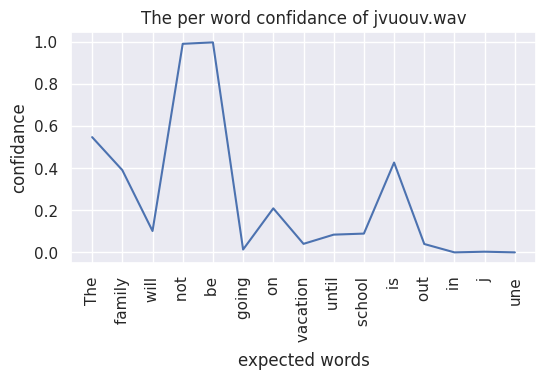

In [5]:
target_idx = 35553

curve = logit[target_idx].numpy().copy()

words = []
for i, x in enumerate(curve):
    if np.isnan(x): break
    words.append(processor.tokenizer.decode(tokens[target_idx][4+i]))

f, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(torch.sigmoid(logit[target_idx]).cpu())
ax.set_xticks(list(range(len(words))), words)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('The per word confidance of {}'.format(df.loc[target_idx].filename))
ax.set_ylabel('confidance')
ax.set_xlabel('expected words')
